In [1]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks",font_scale = 1.8)
from math import ceil
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
#### PARAMETERS

project_name = 'JealsaML'

# DATASET
dataset_root = 'data\\clean\\Pequeno.csv'
dtypes = {'Partida':str, 'Agrupacion':str,'MP':str}
dates = ['FechaInicio']

target = 'RtoLomo'

In [3]:
## CARGA DE FUNCIONES AUXILIARES

def get_root_path():
    cwd = os.getcwd()
    while str(os.getcwd()).split('\\')[-1] != project_name:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path()

sys.path.insert(0, ROOT_DIR)

from src.viz.categorical_numerical import plot_box
from src.viz.univariate import plot_histograma

# Carga de datos

In [4]:
# Carga del dataset
mypath = os.path.join(ROOT_DIR, dataset_root)         
df = pd.read_csv(mypath, dtype=dtypes, parse_dates=dates)
df.columns

Index(['PartidaID', 'Partida', 'FechaInicio', 'Agrupacion', 'ZonaPesca',
       'Proveedor', 'Origen', 'Lomera', 'MP', 'TipoMP', 'NombreMP',
       'EspecieMP', 'TipoCodeMP', 'PequeñoMP', 'VentrescaMP', 'PlantaMP',
       'PesoMedio', 'PesoPartida', 'PesoVersiones', 'MinutosPelado',
       'PesoPales', 'RtoLimpieza', 'MinutosPersonaKg', 'DiasFrigorifico',
       'ZonaFAO', 'Sal', 'Histamina', 'Mercurio', 'Oxidacion', 'Rechazo',
       'Rechazos', 'TipoPesca', 'Carguero'],
      dtype='object')

In [7]:
df.loc[df.Rechazo.isna(), 'Partida'].reset_index(drop=True)

0      0016080118
1      0042100118
2      0058110118
3      0074120118
4      0079120118
5      0099150118
6      0134160118
7      0121160118
8      0145170118
9      0162180118
          ...    
143    5383201218
144    0024070119
145    0504070219
146    0773210219
147    0982050319
148    1188150319
149    1584090419
150    1624110419
151    1625110419
152    1626110419
Name: Partida, Length: 153, dtype: object

# Preprocesado

In [49]:
# PREPROCESSING

## ROW SELECTION
def select_rows(df):
    df = df.loc[~df.PesoPales.isna()]
    df = df.loc[df.RtoLimpieza > 0.3]
    df = df.loc[df.ZonaPesca != 'Pacifico']
    
    df = df.reset_index(drop=True)
    return df

df = select_rows(df)

df = df.loc[~df.Rechazo.isna()]
df['RtoLomo'] = ((df['PesoPales']) / (df['Rechazo'] + df['PesoPales']))
df['RtoMaximo'] = 100 - (df['PesoPartida'] - df['PesoPales'] - df['Rechazo'])/(df['PesoPartida']) 
df = df.loc[df.RtoMaximo>0.2]

df = df.reset_index(drop=True)

df.columns

Index(['PartidaID', 'Partida', 'FechaInicio', 'Agrupacion', 'ZonaPesca',
       'Proveedor', 'Origen', 'Lomera', 'MP', 'TipoMP', 'NombreMP',
       'EspecieMP', 'TipoCodeMP', 'PequeñoMP', 'VentrescaMP', 'PlantaMP',
       'PesoMedio', 'PesoPartida', 'PesoVersiones', 'MinutosPelado',
       'PesoPales', 'RtoLimpieza', 'MinutosPersonaKg', 'DiasFrigorifico',
       'ZonaFAO', 'Sal', 'Histamina', 'Mercurio', 'Oxidacion', 'Rechazo',
       'Rechazos', 'TipoPesca', 'Carguero', 'RtoLomo', 'RtoMaximo'],
      dtype='object')

In [50]:
df.to_csv("Rendemento.csv", index=False)

# Graficas

## Rendimiento Lomo - Univariate

In [51]:
df.RtoLomo.describe()

count    449.000000
mean       0.964340
std        0.023777
min        0.861473
25%        0.955810
50%        0.970969
75%        0.980831
max        1.000000
Name: RtoLomo, dtype: float64

<Figure size 1440x720 with 0 Axes>

No handles with labels found to put in legend.


Text(0.5,0,'Rto Lomo [%]')

Text(0.5,1,'Histograma - Rendimiento Pelado Lomo')

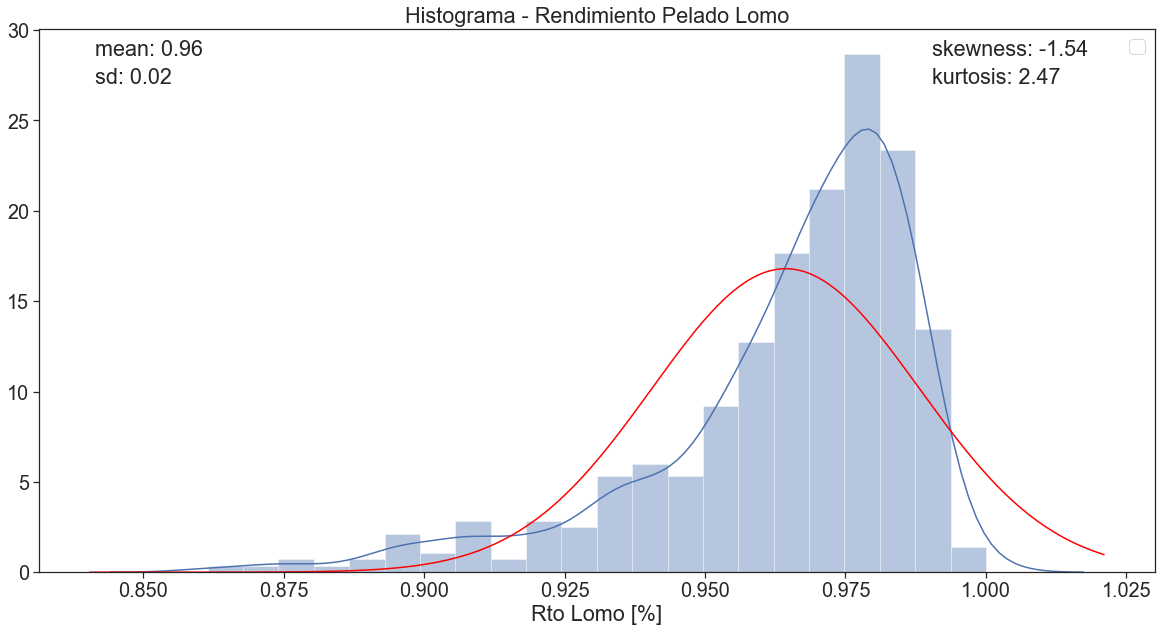

In [52]:
plt.figure(figsize=(20,10))
plot_histograma(df.RtoLomo)
plt.xlabel("Rto Lomo [%]")
plt.title("Histograma - Rendimiento Pelado Lomo")


## Rendimiento Máximo

<Figure size 1440x720 with 0 Axes>

No handles with labels found to put in legend.


Text(0.5,0,'Rto Lomo [%]')

Text(0.5,1,'Histograma - Rendimiento Pelado Máximo')

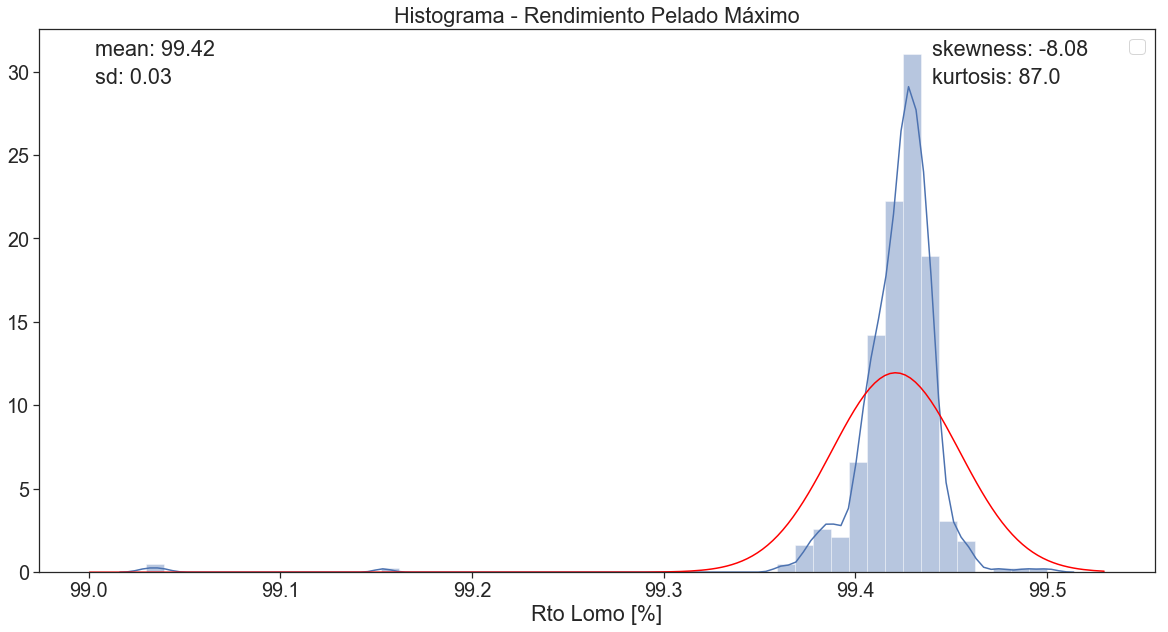

In [53]:
plt.figure(figsize=(20,10))
plot_histograma(df.RtoMaximo)
plt.xlabel("Rto Lomo [%]")
plt.title("Histograma - Rendimiento Pelado Máximo")

## Rendimiento Pelado

<Figure size 1440x720 with 0 Axes>

No handles with labels found to put in legend.


Text(0.5,0,'Rto Lomo [%]')

Text(0.5,1,'Histograma - Rendimiento Pelado')

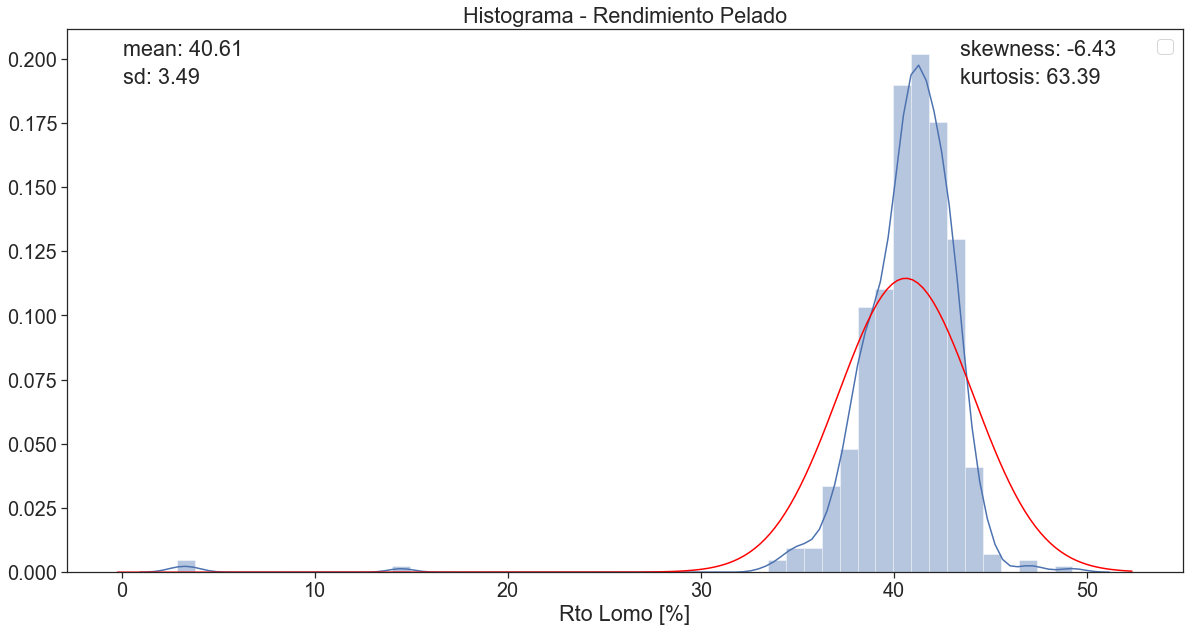

In [54]:
plt.figure(figsize=(20,10))
plot_histograma(df.RtoLimpieza)
plt.xlabel("Rto Lomo [%]")
plt.title("Histograma - Rendimiento Pelado")

# Ajustes

## Ajustamos el Rto Lomo a una Beta

<Figure size 1440x720 with 0 Axes>

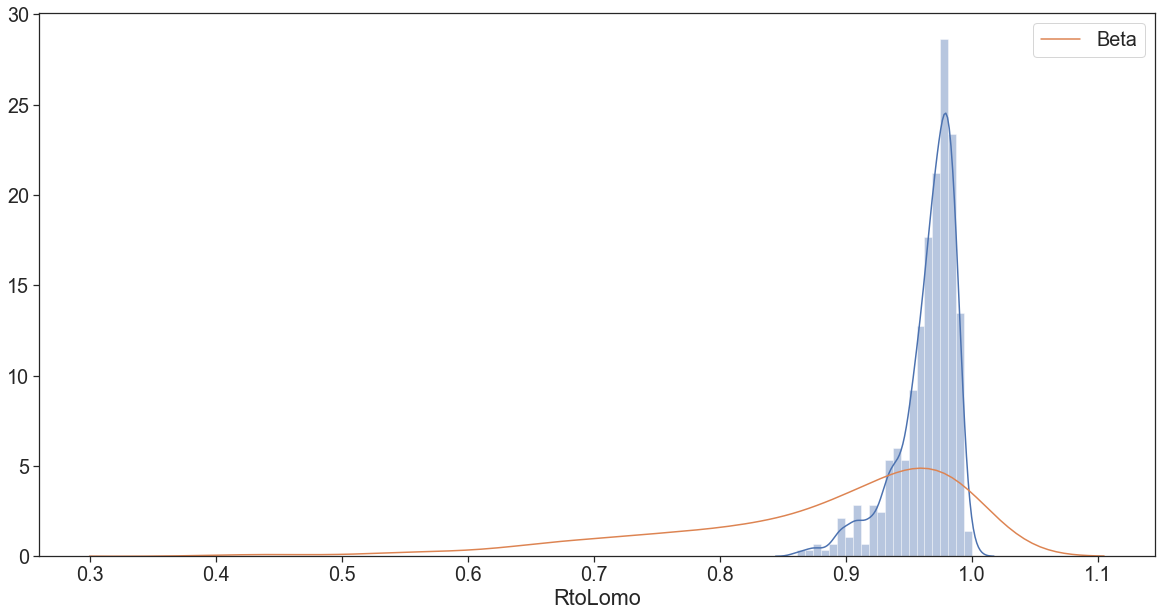

In [55]:
from scipy.stats import beta, lognorm

a,b, loc, scale = beta.fit(df.RtoLomo, floc=0)
b = beta.rvs(a, b, size=len(df.RtoLomo))
s, _, _ = lognorm.fit(df.RtoLomo)

ln = lognorm.rvs(s, size=len(df.RtoLomo))


plt.figure(figsize=(20,10))
ax = sns.distplot(df.RtoLomo, bins = None)
sns.kdeplot(b, label='Beta')
#sns.kdeplot(ln, label='Log Normal')

In [56]:
df['RtoLomo2'] = 1 - df['RtoLomo']

<Figure size 1440x720 with 0 Axes>

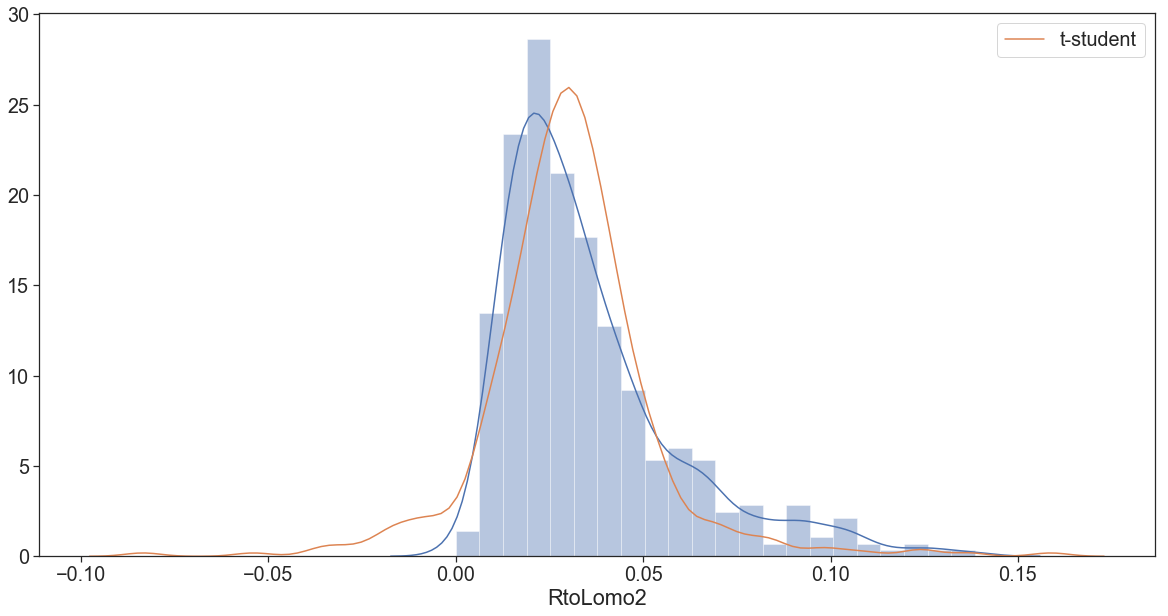

In [59]:
from scipy.stats import t

dfr, loc, scale = t.fit(df.RtoLomo2)

t_fit = t.rvs(loc=loc,scale=scale,df=dfr, size=len(df.RtoLomo2))

plt.figure(figsize=(20,10))
ax = sns.distplot(df.RtoLomo2, bins = None)
sns.kdeplot(t_fit, label='t-student')

## Ajustamos o rendemento máximo a unha normal

In [ ]:
from scipy.stats import norm

# Generate some data for this demonstration.
mu, std = norm.fit(df.RtoMaximo)

fit_normal = np.random.normal(mu, std, len(df.RtoLomo))

In [ ]:
rto = (fit_normal * df.RtoLomo) / 100

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.distplot(df.RtoLimpieza, bins = None)
sns.kdeplot(rto, label='Rto Fitted')